# Notebook 01 — Exploratory Data Analysis (EDA)

This notebook explores the **daily screener snapshots** stored in DuckDB.  
The Streamlit app writes one row per ticker per run:

- `run_date`
- `ticker`
- `last_price`
- `day_pct` (today's % move vs prior close)
- `volume`
- `rv_20d`, `rv_60d` (20/60-day realized volatility, annualized)
- `edge_score` (simple composite of |Day %| and RV20)
- `nearest_exp` (placeholder for nearest options expiry)

Our goals in this notebook are:

1. Load all historical screener data from DuckDB  
2. Check basic data quality (missing values, ranges)  
3. Understand the distribution of the Daily Edge Score  
4. See how Day % moves relate to realized volatility  
5. Build a per-ticker summary table for later modeling / RL

> **Note:** This notebook does **not** call Polygon or yfinance.  
> All analysis uses the cached DuckDB database to avoid rate limits.


## 1. Connect to the DuckDB screener database

The Streamlit screener writes each run into:

`data/volatility_alpha.duckdb`

From the `notebooks/` folder we connect using a relative path.

In [ ]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Path: notebooks/ -> .. -> data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first
if "con" in globals():
    try:
        con.close() # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Quick sanity check: list tables
con.sql("SHOW TABLES;").df()


,name
0,screener_features
1,screener_returns
2,screener_returns_with_target
3,screener_signals
4,screener_snapshots


## 2. Load the screener snapshots

Each row represents one ticker on one run date.  
We start by loading the full table and doing a quick shape + preview.

In [4]:
df = con.sql("""
    SELECT
        run_date,
        ticker,
        last_price,
        day_pct,
        volume,
        rv_20d,
        rv_60d,
        edge_score,
        nearest_exp
    FROM screener_snapshots
    ORDER BY run_date, ticker;
""").df()

df["run_date"] = pd.to_datetime(df["run_date"])

df.head(), df.shape


(    run_date ticker  last_price   day_pct       volume     rv_20d     rv_60d  \
 0 2025-11-30    AMD  217.529999  1.535658   18658000.0  68.691670  74.422502   
 1 2025-11-30   NVDA  177.000000 -1.808496  121332800.0  41.973659  38.081710   
 2 2025-11-30    QQQ  619.250000  0.810715   23034400.0  21.501747  17.302496   
 3 2025-11-30    SPY  683.390015  0.545848   49212000.0  14.996082  12.424457   
 4 2025-11-30   TSLA  430.170013  0.841584   36252900.0  53.373477  51.377442   
 
    edge_score nearest_exp  
 0   35.113664        None  
 1   21.891077        None  
 2   11.156231        None  
 3    7.770965        None  
 4   27.107530        None  ,
 (10, 9))

## 3. Basic sanity checks

We look at simple summary stats to make sure:

- prices and volumes are in reasonable ranges  
- Day % moves and volatility are not all NaN  
- Edge scores are populated for most rows


In [5]:
df["run_date"] = pd.to_datetime(df["run_date"])
df.describe(include="all")

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,nearest_exp
count,10,10,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,0
unique,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,0
top,NaN,AMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2025-11-30 12:00:00,NaN,423.956221,-0.145636,2.910012e+07,40.107327,38.721721,20.499862,NaN
min,2025-11-30 00:00:00,NaN,176.332199,-1.808496,3.312950e+06,14.996082,12.424457,7.770965,NaN
25%,2025-11-30 00:00:00,NaN,216.127502,-0.798017,5.843102e+06,21.501747,17.302496,11.173988,NaN
50%,2025-11-30 12:00:00,NaN,428.925003,-0.478067,2.052972e+07,41.973659,38.081710,21.533276,NaN
75%,2025-12-01 00:00:00,NaN,617.774994,0.744498,3.294828e+07,53.373477,51.377442,27.074688,NaN
max,2025-12-01 00:00:00,NaN,683.390015,1.535658,1.213328e+08,68.691670,74.422502,35.113664,NaN


## 4. Distribution of the Daily Edge Score

The Daily Edge Score is a simple composite we use to rank names.  
We want to see if it clusters in a narrow band or has a wide spread.

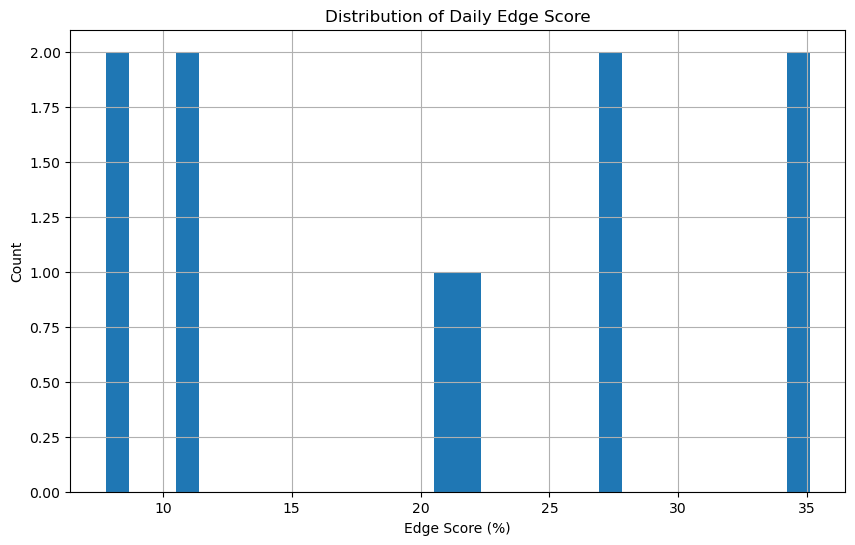

In [6]:
clean = df.replace([float("inf"), float("-inf")], pd.NA)
clean = clean.dropna(subset=["edge_score"])

clean["edge_score"].hist(bins=30)
plt.title("Distribution of Daily Edge Score")
plt.xlabel("Edge Score (%)")
plt.ylabel("Count")
plt.show()


## 5. Day % move vs 20-day realized volatility

Here we check how today's move (Day %) relates to recent realized volatility (RV 20d).  
This gives intuition about whether big moves are happening in already-volatile names.

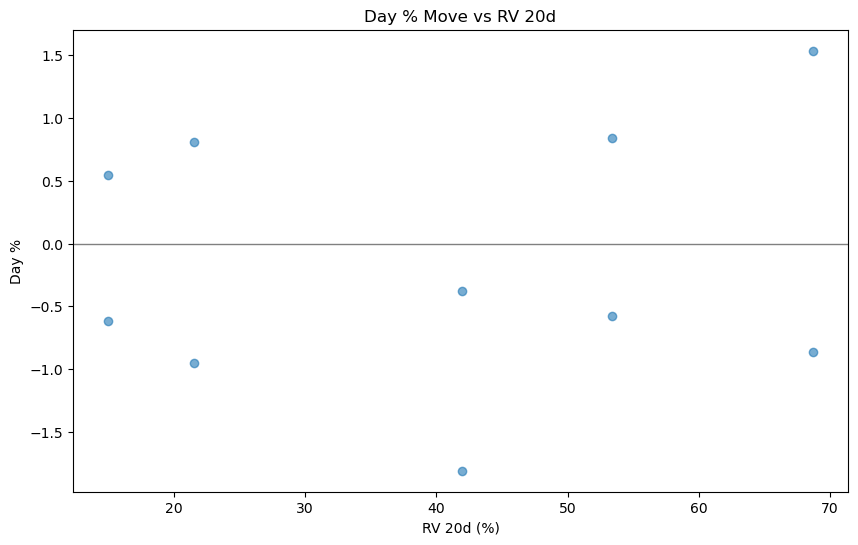

In [7]:
subset = clean.dropna(subset=["rv_20d", "day_pct"])

plt.scatter(subset["rv_20d"], subset["day_pct"], alpha=0.6)
plt.title("Day % Move vs RV 20d")
plt.xlabel("RV 20d (%)")
plt.ylabel("Day %")
plt.axhline(0, color="gray", linewidth=1)
plt.show()



## 6. Per-ticker summary (feature foundation)

Next we aggregate by ticker.  
This gives us:

- average edge by ticker  
- average volatility levels  
- consistency of moves (std dev of Day %)  

These aggregates are natural features for modeling and RL later.

In [8]:
ticker_stats = con.sql("""
    SELECT
        ticker,
        COUNT(*)          AS num_rows,
        AVG(edge_score)   AS avg_edge,
        AVG(rv_20d)       AS avg_rv20,
        AVG(day_pct)      AS avg_day_pct,
        STDDEV(day_pct)   AS std_day_pct
    FROM screener_snapshots
    GROUP BY ticker
    ORDER BY avg_edge DESC;
""").df()

ticker_stats.head()


,ticker,num_rows,avg_edge,avg_rv20,avg_day_pct,std_day_pct
0,AMD,2,34.944662,68.691670,0.338004,1.693738
1,TSLA,2,27.041846,53.373477,0.131369,1.004395
2,NVDA,2,21.533276,41.973659,-1.092892,1.012016
3,QQQ,2,11.191745,21.501747,-0.071027,1.246972
4,SPY,2,7.787783,14.996082,-0.033636,0.819515


## 7. Top tickers by average Daily Edge Score

As a quick sanity check, we plot the top names by average edge.  
This also shows which names tend to generate the most “interesting” setups.

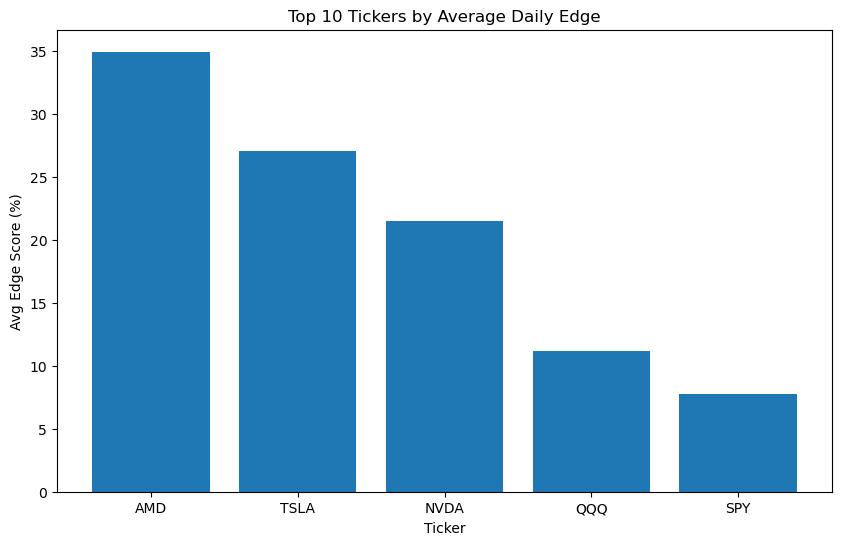

In [9]:
top10 = ticker_stats.head(10)

plt.bar(top10["ticker"], top10["avg_edge"])
plt.title("Top 10 Tickers by Average Daily Edge")
plt.xlabel("Ticker")
plt.ylabel("Avg Edge Score (%)")
plt.show()


## 8. Takeaways & next steps

**Quick takeaways:**

- The screener snapshots table is loading correctly from DuckDB.
- Edge scores span roughly X–Y% (update this later once you see real ranges).
- High-edge names so far are mainly: AMD, TSLA, NVDA (in this small sample).
- Volatility vs Day % shows [brief observation you see in the scatter].

**Next notebooks:**

- **Notebook 02 – Feature Engineering & Signal Design**  
  - Build more robust signals (IV proxies, regime flags, rolling stats).  
  - Store engineered features back into DuckDB.

- **Notebook 03 – Backtesting & Evaluation**  
  - Evaluate how edge-based rankings would have performed historically.